# Problem statement


*   The proliferation of social media enables people to express their opinions widely online. However, at the same time, this has resulted in the emergence of conflict and hate, making online environments uninviting for users. Although researchers have found that hate is a problem across multiple platforms, there is a lack of models for online hate detection.
*   Online hate, described as abusive language, aggression, cyberbullying, hatefulness and many others has been identified as a major threat on online social media platforms. Social media platforms are the most prominent grounds for such toxic behaviour.

*   There has been a remarkable increase in the cases of cyberbullying and trolls on various social media platforms. Many celebrities and influences are facing backlashes from people and have to come across hateful and offensive comments. This can take a toll on anyone and affect them mentally leading to depression, mental illness, self-hatred and suicidal thoughts. 
*   Internet comments are bastions of hatred and vitriol. While online anonymity has provided a new outlet for aggression and hate speech, machine learning can be used to fight it. The problem we sought to solve was the tagging of internet comments that are aggressive towards other users. This means that insults to third parties such as celebrities will be tagged as unoffensive, but “u are an idiot” is clearly offensive.





# Objective

*   Our goal is to **build a prototype of online hate and abuse comment classifier** which can used to classify hate and offensive comments so that it can be controlled and restricted from spreading hatred and cyberbullying. 




#Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import spacy
import sklearn
import random

import operator
import math
import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud



import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import cross_val_score

import joblib

#Importing Training DataSet

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving train.csv to train.csv


In [ ]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
df_train.head(10)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


#Basic Info on the train dataset

In [ ]:
#Basic Info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
#column names
df_train.columns

Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

In [ ]:
#datatypes of the Attributes
df_train.dtypes

id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

In [ ]:
#No of rows and columns
df_train.shape

(159571, 8)

# Finding Missing Values

In [ ]:
df_train.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

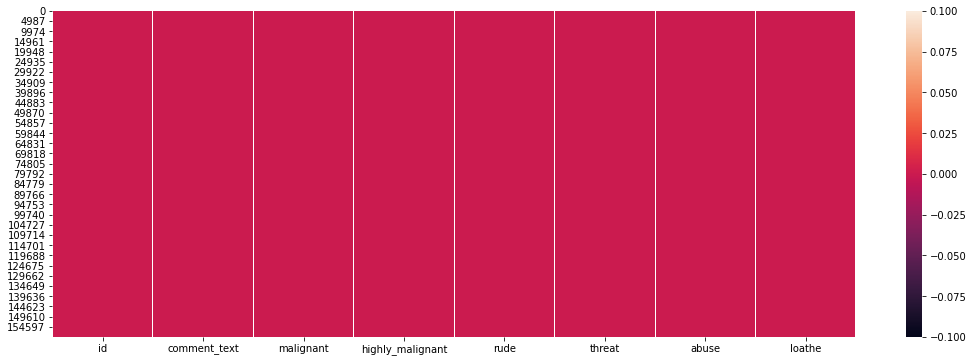

In [ ]:
#Graphical Visuvalization of Missing values
plt.figure(figsize=(18,6))
sns.heatmap(df_train.isnull())

#Creating Extra columns for further Observation

In [ ]:
#creating column to find the total of malignant  
df_train['total'] = df_train.malignant + df_train.highly_malignant + df_train.rude + df_train.threat + df_train.abuse + df_train.loathe

#creating column to find the total length of the Words
df_train['comment_text_length'] = df_train['comment_text'].apply(lambda x: len(x.split()))

#creating column to find the total length of the characters
df_train['comment_caract_len'] = df_train['comment_text'].str.len()

#creating column to find whether comment is malignant or neutral
df_train['type'] = df_train['total'].apply(lambda x: 'Neutral' if x==0 else 'Malignant')

In [ ]:
df_train.head(10)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,total,comment_text_length,comment_caract_len,type
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,264,Neutral
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,112,Neutral
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,233,Neutral
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,622,Neutral
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,67,Neutral
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0,13,65,Neutral
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4,8,44,Malignant
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0,20,115,Neutral
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0,83,472,Neutral
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,0,12,70,Neutral


#EDA

Analytical Exploration on Labels

In [ ]:
#Column type
df_train.groupby('type').size()



type
Malignant     16225
Neutral      143346
dtype: int64

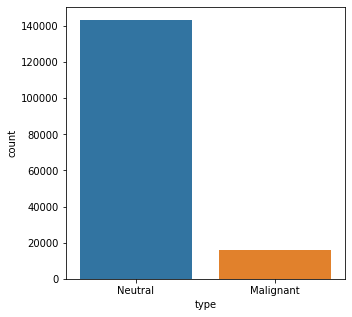

In [ ]:
#Visualization
plt.figure(figsize=(5,5))
sns.countplot(df_train["type"])

In [ ]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count=df_train.iloc[:,2:-4].sum()
data_count

malignant           15294
highly_malignant     1595
rude                 8449
threat                478
abuse                7877
loathe               1405
dtype: int64

Text(0.5, 0, 'Type ')

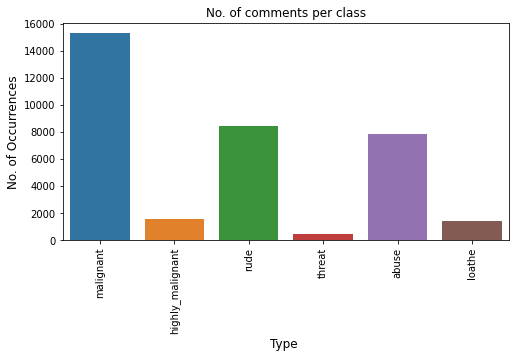

In [ ]:
# Plot a chart with the following size
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category. alpha = 0.8 to make the bars more translucent
ax = sns.barplot(data_count.index, data_count.values)
plt.xticks(rotation='vertical')
plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

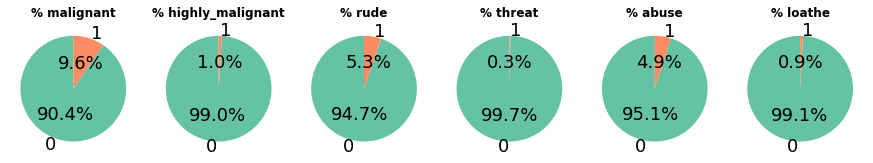

In [ ]:
sns.set_palette("Set2")

labels = ['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']
labels_setup = ['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']
plt.rcParams['font.size'] = 24

plt.figure(figsize=(18, 7))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
for i in range(1, 7):
    plt.subplot(1, 7, i)
    plt.pie(df_train[labels[i-1]].value_counts(), labels=df_train[labels[i-1]].unique(), shadow=False, autopct='%1.1f%%', startangle=90, pctdistance=0.5, textprops={'fontsize': 18})
    title = '% ' + str(labels[i-1])
    plt.title(title, fontweight="bold", size=12)

#Analytical Exploration on comment_text

**Analysis on comment_text(Number of words)**

In [ ]:
without_malignant = df_train[df_train.total == 0]['comment_text'].apply(lambda x: len(x.split()))
with_malignant = df_train[df_train.total >= 1]['comment_text'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Comment_text length in terms of word count')

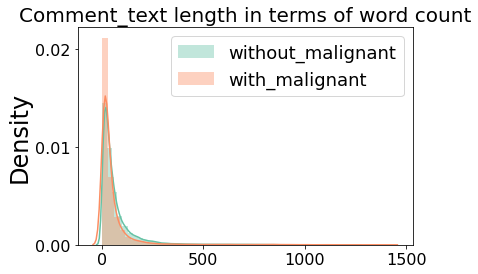

In [ ]:
sns.distplot(without_malignant, label='without_malignant')
sns.distplot(with_malignant, label='with_malignant')
plt.legend(fontsize=18)
plt.xlabel(None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Comment_text length in terms of word count", fontsize=20)

### Analysis on comment_text(Number of characters)

In [ ]:
without_malignant = df_train[df_train.total == 0]['comment_caract_len']
with_malignant = df_train[df_train.total >= 1]['comment_caract_len']

Text(0.5, 1.0, 'Commentary length analysis (number of characters)')

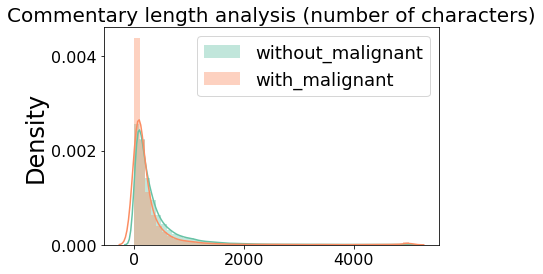

In [ ]:
sns.distplot(without_malignant, label='without_malignant')
sns.distplot(with_malignant, label='with_malignant')
plt.legend(fontsize=18)
plt.xlabel(None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Commentary length analysis (number of characters)", fontsize=20)

# Feature Engineering
- Before moving further in this section first let's find the correlation between the features using Heatmap.

In [ ]:
#correlation
cor=df_train.corr()
cor


,malignant,highly_malignant,rude,threat,abuse,loathe,total,comment_text_length,comment_caract_len
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009,0.869050,-0.052441,-0.054413
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600,0.517967,0.008453,0.010175
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867,0.879731,-0.042205,-0.042910
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128,0.251314,-0.006688,-0.007917
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736,0.869177,-0.043639,-0.045027
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000,0.448341,-0.014493,-0.013628
total,0.869050,0.517967,0.879731,0.251314,0.869177,0.448341,1.000000,-0.047070,-0.048211
comment_text_length,-0.052441,0.008453,-0.042205,-0.006688,-0.043639,-0.014493,-0.047070,1.000000,0.987793
comment_caract_len,-0.054413,0.010175,-0.042910,-0.007917,-0.045027,-0.013628,-0.048211,0.987793,1.000000


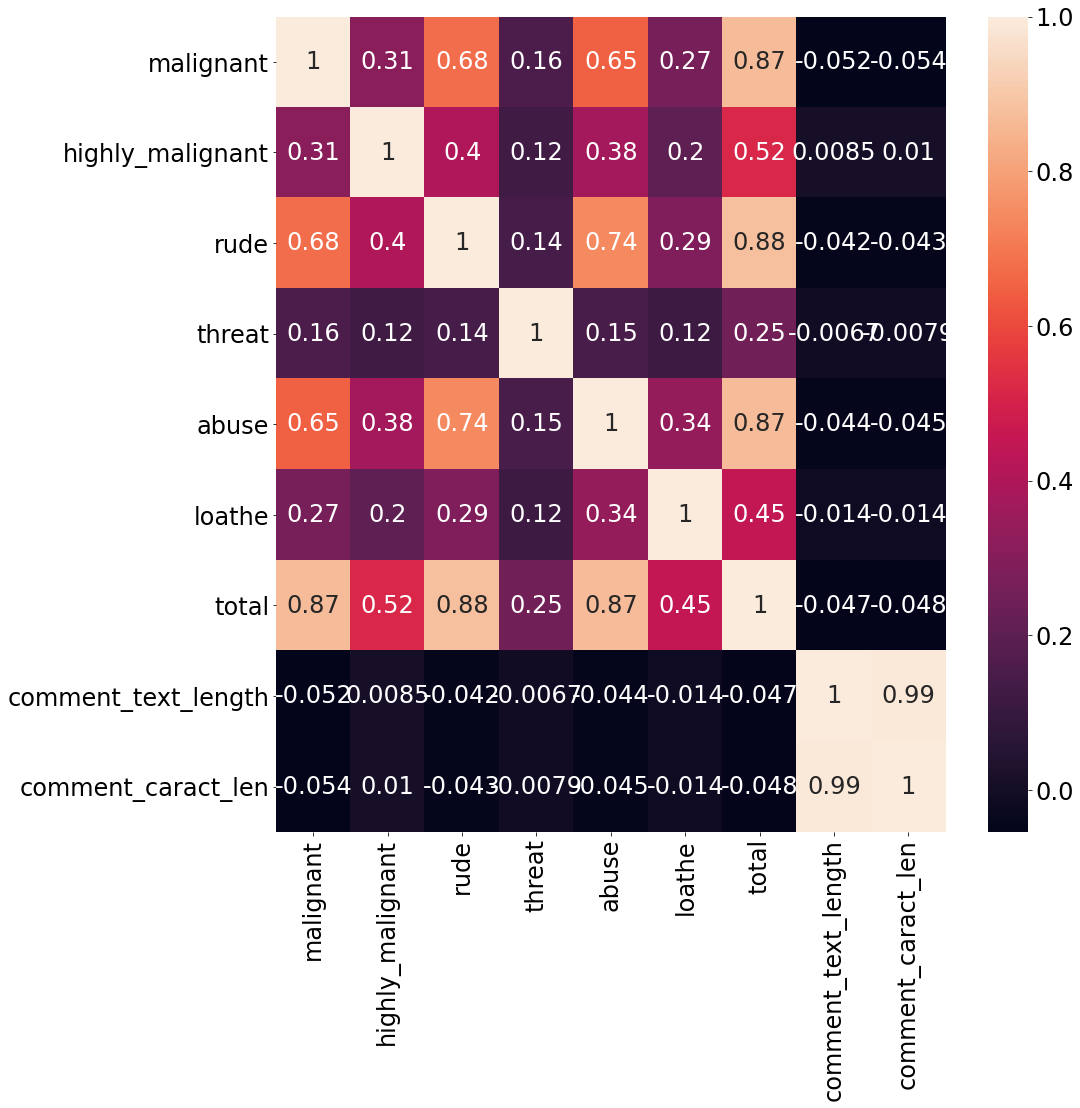

In [ ]:
#Visualization of Correlation
#usind Heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
sns.heatmap((cor),annot=True)


###Observation on correlation b/w labels
- apparent correlation between malignant, rude and abuse

#Preprocess the Comment_text column

**First lets see how the comments look like**

In [ ]:
df_train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
df_train['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

**Observation**

1.   The comments are dirty with '\n' values, symbols, numbers that will not be useful for analysis. We will be removing these further down the pipeline.




###Preprocessing
Preprocessing involved the following steps

1. Removing Punctuations and other special characters
2. Splitting the comments into individual words
3. Removing Stop Words
4. Lemmatising
5. Applying Count Vectoriser
6. Splitting dataset into Training and Testing



In [ ]:
#Converting all the characters in the reviews to lowercase
df_train['comment_text'] = df_train['comment_text'].str.lower()
df_train['comment_text'][1]

"d'aww! he matches this background colour i'm seemingly stuck with. thanks.  (talk) 21:51, january 11, 2016 (utc)"

In [ ]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ',x)

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r'', x)

# Apply all the lambda functions wrote previously through .map on the comments column
df_train['comment_text'] = df_train['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

df_train['comment_text'][8]

'sorry if the word  nonsense  was offensive to you  anyway  i m not intending to write anything in the article wow they would jump on me for vandalism   i m merely requesting that it be more encyclopedic so one can use it for school as a reference  i have been to the selective breeding page but it s almost a stub  it points to  animal breeding  which is a short messy article that gives you no info  there must be someone around with expertise in eugenics     '

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#Remove all the stopwords
stop_words = set(stopwords.words('english') + ['e','ur','im','doin','ure','i','so'])
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

#Lemmetizing
WL = WordNetLemmatizer()
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ' '.join(WL.lemmatize(i) for i in x.split()))
df_train.head(5)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,total,comment_text_length,comment_caract_len,type
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,0,43,264,Neutral
1,000103f0d9cfb60f,aww match background colour seemingly stuck th...,0,0,0,0,0,0,0,17,112,Neutral
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0,42,233,Neutral
3,0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0,0,113,622,Neutral
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,0,13,67,Neutral


In [ ]:
#creating column to find the total length of the cleaned Words
df_train['clean_comment_text_length'] = df_train['comment_text'].apply(lambda x: len(x.split()))

#creating column to find the total length of the cleaned characters
df_train['clean_comment_caract_len'] = df_train['comment_text'].str.len()

df_train.head(2)



,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,total,comment_text_length,comment_caract_len,type,clean_comment_text_length,clean_comment_caract_len
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,0,43,264,Neutral,23,156
1,000103f0d9cfb60f,aww match background colour seemingly stuck th...,0,0,0,0,0,0,0,17,112,Neutral,10,67


In [ ]:
print('Original Length of text', df_train.comment_text_length.sum())
print('Clean Length of text', df_train.clean_comment_text_length.sum())
print('Original Length of character', df_train.comment_caract_len.sum())
print('Clean Length of character', df_train.clean_comment_caract_len.sum())


Original Length of text 10734743
Clean Length of text 5495146
Original Length of character 62893130
Clean Length of character 38658505


#Seperating Our DataSet

we seperate our dataset into 6 section

1. id,comment_text,malignant
2. id,comment_text,highly_malignant
3. id,comment_text,rude
4. id,comment_text,threat
5. id,comment_text,abuse
6. id,comment_text,loathe

In [ ]:
df_train_malignant = df_train.loc[:,['id','comment_text','malignant']]
df_train_hmalignant = df_train.loc[:,['id','comment_text','highly_malignant']]
df_train_rude = df_train.loc[:,['id','comment_text','rude']]
df_train_threat = df_train.loc[:,['id','comment_text','threat']]
df_train_abuse = df_train.loc[:,['id','comment_text','abuse']]
df_train_loathe = df_train.loc[:,['id','comment_text','loathe']]


#WORD CLOUD

Creating word cloud to **show the words which occur most frequently** for each category

In [ ]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [ ]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df_train[df_train[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="white",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

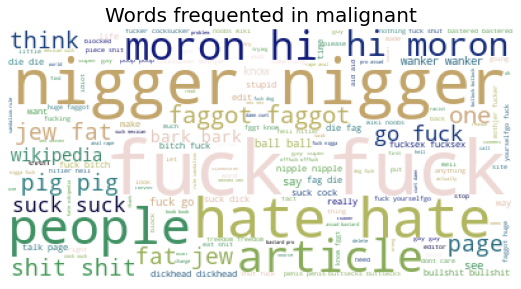

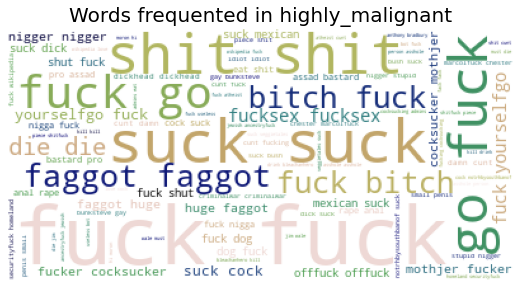

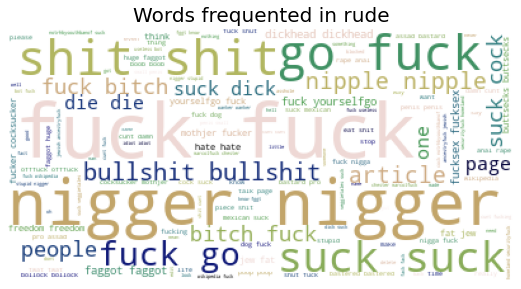

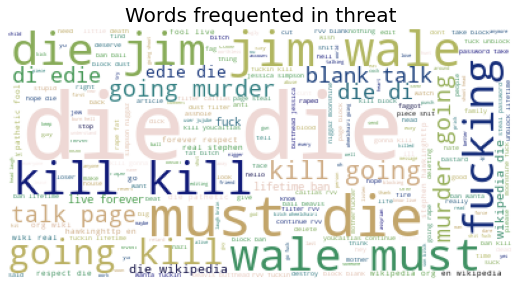

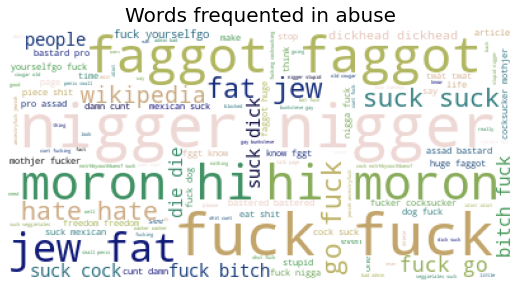

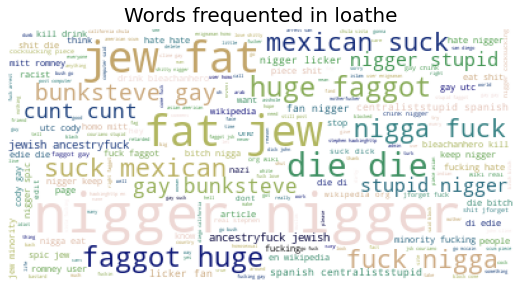

In [ ]:
label=['malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe']
for i in label:
  wordcloud(df_train,i)

#Importing Relevant Libraries

In [ ]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import ML algos
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
bnb = BernoulliNB()
mnb = MultinomialNB()
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

#**Benchmarking Define function**

**TFIDF vectorizer**

   We determined to use TFIDF to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.



**Machine Learning Algorithms**
1.   LogisticRegression
2.   KNeighborsClassifier
3.   MultinomialNB
4.   BernoulliNB
5.   LinearSVC
6.   RandomForestClassifier



**ngram**

gram_range values: (1,1) for unigram

In [ ]:
def cv_tf_train_test(df,label,vectorizer,ngram):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    x = df.comment_text
    y = df[label]

    # Split our data into training and test data 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    x_train_cv1 = cv1.fit_transform(x_train) # Learn the vocabulary dictionary and return term-document matrix
    x_test_cv1  = cv1.transform(x_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
        
    #initializing all models
    lr = LogisticRegression()
    lr.fit(x_train_cv1, y_train)
    print("Lr fit done")
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train_cv1, y_train)
    print("KN fit done")

    bnb = BernoulliNB()
    bnb.fit(x_train_cv1, y_train)
    print("BNB fit done")
        
    mnb = MultinomialNB()
    mnb.fit(x_train_cv1, y_train)
    print("MNB fit done")
        
    svm_model = LinearSVC()
    svm_model.fit(x_train_cv1, y_train)
    print("SVC fit done")

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(x_train_cv1, y_train)
    print("RF fit done")
        
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score of {}'.format(label):[f1_score(lr.predict(x_test_cv1), y_test), f1_score(knn.predict(x_test_cv1), y_test), 
                                f1_score(bnb.predict(x_test_cv1), y_test), f1_score(mnb.predict(x_test_cv1), y_test),
                                f1_score(svm_model.predict(x_test_cv1), y_test), f1_score(randomforest.predict(x_test_cv1), y_test)]} 
                          
    # Create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])
    
    return df_f1

In [ ]:
df_malignant_cv=cv_tf_train_test(df_train_malignant, 'malignant', TfidfVectorizer, (1,1))


Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


In [ ]:
df_malignant_cv

,F1 Score of malignant
Log Regression,0.718808
KNN,0.308465
BernoulliNB,0.646498
MultinomialNB,0.325547
SVM,0.763174
Random Forest,0.710162


In [ ]:
df_hmalignant_cv=cv_tf_train_test(df_train_hmalignant, 'highly_malignant', TfidfVectorizer, (1,1))
df_hmalignant_cv

Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


,F1 Score of highly_malignant
Log Regression,0.357955
KNN,0.209493
BernoulliNB,0.008016
MultinomialNB,0.000000
SVM,0.376658
Random Forest,0.119349


In [ ]:
df_rude_cv=cv_tf_train_test(df_train_rude, 'rude', TfidfVectorizer, (1,1))

Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


In [ ]:
df_rude_cv

,F1 Score of rude
Log Regression,0.731305
KNN,0.328698
BernoulliNB,0.301397
MultinomialNB,0.219673
SVM,0.773980
Random Forest,0.756349


In [ ]:
df_threat_cv=cv_tf_train_test(df_train_threat, 'threat', TfidfVectorizer, (1,1))
df_threat_cv

Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


,F1 Score of threat
Log Regression,0.243902
KNN,0.117647
BernoulliNB,0.000000
MultinomialNB,0.000000
SVM,0.347368
Random Forest,0.093333


In [ ]:
df_abuse_cv=cv_tf_train_test(df_train_abuse, 'abuse', TfidfVectorizer, (1,1))

Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


In [ ]:
df_abuse_cv

,F1 Score of abuse
Log Regression,0.624805
KNN,0.292370
BernoulliNB,0.202050
MultinomialNB,0.088623
SVM,0.657965
Random Forest,0.609351


In [ ]:
df_loathe_cv=cv_tf_train_test(df_train_loathe, 'loathe', TfidfVectorizer, (1,1))
df_loathe_cv

Lr fit done
KN fit done
BNB fit done
MNB fit done
SVC fit done
RF fit done


,F1 Score of loathe
Log Regression,0.271186
KNN,0.183299
BernoulliNB,0.000000
MultinomialNB,0.000000
SVM,0.372881
Random Forest,0.099352


In [ ]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_malignant_cv, df_hmalignant_cv, df_rude_cv, df_threat_cv, df_abuse_cv, df_loathe_cv], axis=1)
f1_all

,F1 Score of malignant,F1 Score of highly_malignant,F1 Score of rude,F1 Score of threat,F1 Score of abuse,F1 Score of loathe
Log Regression,0.718808,0.357955,0.731305,0.243902,0.624805,0.271186
KNN,0.308465,0.209493,0.328698,0.117647,0.292370,0.183299
BernoulliNB,0.646498,0.008016,0.301397,0.000000,0.202050,0.000000
MultinomialNB,0.325547,0.000000,0.219673,0.000000,0.088623,0.000000
SVM,0.763174,0.376658,0.773980,0.347368,0.657965,0.372881
Random Forest,0.710162,0.119349,0.756349,0.093333,0.609351,0.099352


In [ ]:
#Transpose the combined F1 dataframe to make it suitable for presentation on a graph
f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score of malignant,0.718808,0.308465,0.646498,0.325547,0.763174,0.710162
F1 Score of highly_malignant,0.357955,0.209493,0.008016,0.000000,0.376658,0.119349
F1 Score of rude,0.731305,0.328698,0.301397,0.219673,0.773980,0.756349
F1 Score of threat,0.243902,0.117647,0.000000,0.000000,0.347368,0.093333
F1 Score of abuse,0.624805,0.292370,0.202050,0.088623,0.657965,0.609351
F1 Score of loathe,0.271186,0.183299,0.000000,0.000000,0.372881,0.099352


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

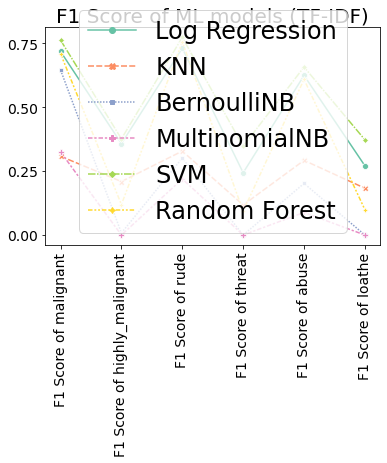

In [ ]:
#Lineplot to see the F1 score
sns.lineplot(data=f1_all_trp, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

OBSERVATION

*   from the F1 score board and the line graph we see LinearSVC and Logistic regression models perform best **(Green and blue lines seem to be the highest)**.

*    so we go with **LinearSVC as our final model**  




#Finding the training and testing score for our final model LinearSVC

In [75]:
def cv_tf_train_test_final(df,label,vectorizer,ngram):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    x = df.comment_text
    y = df[label]

    # Split our data into training and test data 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    x_train_cv1 = cv1.fit_transform(x_train) # Learn the vocabulary dictionary and return term-document matrix
    x_test_cv1  = cv1.transform(x_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
           
    svm_model = LinearSVC()
    svm_model.fit(x_train_cv1, y_train)
    pred_train=svm_model.predict(x_train_cv1)
    pred_test=svm_model.predict(x_test_cv1)
    print("the score of {} is".format(label))
    print("training accuracy score  :",accuracy_score(y_train,pred_train)*100)
    print("testing accuracy score  :",accuracy_score(y_test,pred_test)*100)
    
    print("*********************************************************************")
    print("\n\n")
    
  

In [76]:
malignant=cv_tf_train_test_final(df_train_malignant,'malignant',TfidfVectorizer, (1,1))
print(malignant)
high_malignant=cv_tf_train_test_final(df_train_hmalignant,'highly_malignant',TfidfVectorizer, (1,1))
print(high_malignant)
rude=cv_tf_train_test_final(df_train_rude,'rude',TfidfVectorizer, (1,1))
print(rude)
threat=cv_tf_train_test_final(df_train_threat,'threat',TfidfVectorizer, (1,1))
print(threat)
abuse=cv_tf_train_test_final(df_train_abuse,'abuse',TfidfVectorizer, (1,1))
print(abuse)
loathe=cv_tf_train_test_final(df_train_loathe,'loathe',TfidfVectorizer, (1,1))
print(loathe)


the score of malignant is
training accuracy score  : 98.53893051862596
testing accuracy score  : 95.95379344919786
*********************************************************************



None
the score of highly_malignant is
training accuracy score  : 99.60429368212786
testing accuracy score  : 99.01821524064172
*********************************************************************



None
the score of rude is
training accuracy score  : 99.29184683837813
testing accuracy score  : 97.8588736631016
*********************************************************************



None
the score of threat is
training accuracy score  : 99.92748368382887
testing accuracy score  : 99.74097593582889
*********************************************************************



None
the score of abuse is
training accuracy score  : 98.97671420514061
testing accuracy score  : 97.04420120320856
*********************************************************************



None
the score of loathe is
training accuracy 

# Sample Prediction

In [99]:
X = df_train_malignant.comment_text
y = df_train_malignant['malignant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
svm_model = LinearSVC()
svm_model.fit(X_train_fit, y_train)
svm_model.predict(X_test_fit)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [103]:

comment1 = ['You piece of shit']
comment2 = ['What is up garden apple doing']


comment1_vect = tfv.transform(comment1)
svm_model.predict(comment1_vect)

array([1], dtype=int64)

In [104]:
comment2_vect = tfv.transform(comment2)
svm_model.predict(comment2_vect)

array([0], dtype=int64)

#Observation

1.   The comment 1 is a malignant word and the prediction shows 1 which means the comment is malignant
2.   The comment 2 is an ordinary word and the prediction shows 0 which means the comment is not malignant

this shows our svm model prediction is good 



#Saving the model

In [113]:
def pickle_model(df, label):
    
    X = df.comment_text
    y = df[label]

    # Initiate a Tfidf vectorizer
    tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    
    # Convert the X data into a document term matrix dataframe
    X_vect = tfv.fit_transform(X)  
    
    
        
    svm_model = LinearSVC()
    svm_model.fit(X_vect, y)

    # Create a new pickle file based on random forest
    with open(r"{}.pkl".format(label + '_model'), "wb") as f:  
        pickle.dump(svm_model, f)

In [114]:
p_malig=pickle_model(df_train_malignant, 'malignant')

In [115]:
from google.colab import files
files.download('malignant_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#USING TEST DATA

#Loading the test data


In [79]:
from google.colab import files
uploaded=files.upload()

Saving test.csv to test.csv


In [88]:
import io
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
df_test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


#Finding any missing value in test data

In [89]:
df_test.isnull().sum()

id              0
comment_text    0
dtype: int64

#Preprocessing Test Data

###Preprocessing
Preprocessing involved the following steps

1. Removing Punctuations and other special characters
2. Splitting the comments into individual words
3. Removing Stop Words
4. Lemmatising
5. Applying Count Vectoriser
6. Splitting dataset into Training and Testing



In [90]:
#Converting all the characters in the reviews to lowercase
df_test['comment_text'] = df_test['comment_text'].str.lower()
df_test['comment_text'][1]

'== from rfc == \n\n the title is fine as it is, imo.'

In [91]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ',x)

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r'', x)

# Apply all the lambda functions wrote previously through .map on the comments column
df_test['comment_text'] = df_test['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

df_test['comment_text'][1]

'   from rfc       the title is fine as it is  imo '

In [92]:
#Remove all the stopwords
stop_words = set(stopwords.words('english') + ['e','ur','im','doin','ure','i','so'])
df_test['comment_text'] = df_test['comment_text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

#Lemmetizing
WL = WordNetLemmatizer()
df_test['comment_text'] = df_test['comment_text'].apply(lambda x: ' '.join(WL.lemmatize(i) for i in x.split()))
df_test.head(5)

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,rfc title fine imo
2,00013b17ad220c46,source zawe ashton lapland
3,00017563c3f7919a,look back source information updated correct f...
4,00017695ad8997eb,anonymously edit article


In [122]:
tfv = TfidfVectorizer(ngram_range=(1,1),max_features=10000)
X_test_fit2 = tfv.fit_transform(df_test)
X_test_fit2

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [118]:
fitted_model=pickle.load(open("malignant_model.pkl","rb"))
fitted_model

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [120]:
# Loading the Model
prediction=fitted_model.predict(X_test_fit)
prediction

ValueError: ignored